# STEP 0. Import

In [1]:
import os
import zipfile
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<br/>
<br/>
<br/>
<br/>

# STEP 1. Load Dataset

In [2]:
# 데이터 다운로드 및 압축 풀기
url = 'https://storage.googleapis.com/download.tensorflow.org/data/rps.zip'
urllib.request.urlretrieve(url, 'rps.zip')
local_zip = 'rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('data/')
zip_ref.close()

In [3]:
# data/rps 경로의 파일 확인
os.listdir('data/rps/')

['rock', 'paper', 'scissors']

In [4]:
# scissors 폴더의 첫 번째 데이터 경로
sample_data_dir = f"data/rps/scissors/{os.listdir('data/rps/scissors')[0]}"
sample_data_dir

'data/rps/scissors/scissors02-110.png'

In [5]:
# sample_data를 로드
from tensorflow.keras.preprocessing.image import load_img, img_to_array
sample_data = load_img(sample_data_dir, target_size=(150, 150))
sample_data = img_to_array(sample_data) / 255

# sample_data의 shape와 첫 번째 픽셀을 출력
sample_data.shape, sample_data[0, 0, :]

((150, 150, 3), array([0.99215686, 0.99215686, 0.99215686], dtype=float32))

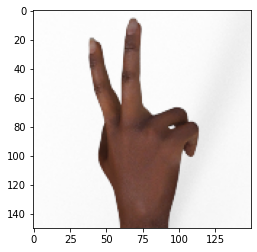

In [6]:
# sample_data를 시각화.

plt.imshow(sample_data)



plt.show()

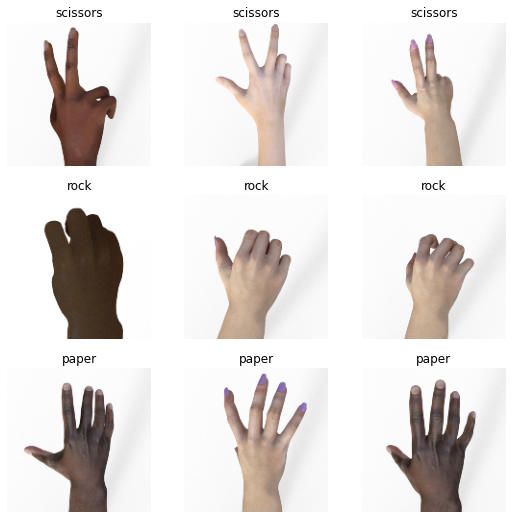

In [7]:
# 'scissors', 'rock', 'paper'의 각 이미지 3개씩 subplot.
from tensorflow.keras.preprocessing.image import load_img, img_to_array

plt.figure(figsize = (9,9))

for i, c in enumerate(['scissors', 'rock', 'paper']) :
    files = os.listdir(f'data/rps/{c}')[:3]
    for j, file in enumerate(files) :
        plt.subplot(3,3, 3*i + j + 1)

        # 이미지 로드
        image = load_img(f'data/rps/{c}/{file}', target_size=(150, 150))
        image = img_to_array(image) / 255
        
        # plot
        plt.imshow(image)
        plt.axis(False)
        plt.title(c)
plt.show()

<br/>
<br/>
<br/>
<br/>

# STEP 2. 전처리 (ImageDataGenerator)
`ImageDataGenerator`를 정의

다음의 옵션 값들로 Image Aumentation(이미지 변형) 옵션을 적절히 조절

* `rescale`: 이미지의 픽셀 값을 조정
* `rotation_range`: 이미지 회전
* `width_shift_range`: 가로 방향으로 이동
* `height_shift_range`: 세로 방향으로 이동
* `shear_range`: 이미지 굴절
* `zoom_range`: 이미지 확대
* `horizontal_flip`: 횡 방향으로 이미지 반전
* `fill_mode`: 이미지를 이동이나 굴절시켰을 때 빈 픽셀 값에 대하여 값을 채우는 방식
* `validation_split`: validation set의 구성 비율

In [8]:
dir_path = 'data'

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
training_datagen = ImageDataGenerator(
      rescale=1./255, 
      rotation_range=20, # 
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest',
      validation_split=0.2)






In [43]:
# training_generator 생성 
training_generator = training_datagen.flow_from_directory('data/rps',
        target_size=(150, 150),
        batch_size=128,
        class_mode='sparse',
        subset='training')



Found 2016 images belonging to 3 classes.


In [44]:
# validation_generator 생성 
validation_generator = training_datagen.flow_from_directory(
    'data/rps', 
    target_size=(150, 150),
    batch_size=128,
    class_mode='sparse',
    subset='validation') 





Found 504 images belonging to 3 classes.


<br/>
<br/>
<br/>
<br/>

# STEP 3. 모델 정의 (Sequential)

In [45]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential

In [46]:
model = Sequential([
    Conv2D(64, 3, activation="ReLU", input_shape=(150,150,3)),
    Conv2D(64, 3, activation="ReLU"),
    MaxPooling2D(2,2),
    Conv2D(128, 3, activation="ReLU"),
    Conv2D(128, 3, activation="ReLU"),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.3),
    Dense(512, activation="ReLU"),
    Dense(3, activation="softmax")


    
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 conv2d_13 (Conv2D)          (None, 146, 146, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 71, 71, 128)       73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 69, 69, 128)       147584    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                  

<br/>
<br/>
<br/>
<br/>

# STEP 4. 컴파일 (compile)

In [47]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

<br/>
<br/>
<br/>
<br/>

# STEP 5. ModelCheckpoint 생성


In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

<br/>
<br/>
<br/>
<br/>

# STEP 6. 학습 (fit)

In [49]:
history = model.fit_generator(
      training_generator,
      steps_per_epoch=16,
      epochs=25,
      validation_data=validation_generator,
      validation_steps=3,
      verbose=2,
      callbacks=checkpoint
      )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/25

Epoch 1: val_loss improved from inf to 1.09658, saving model to tmp_checkpoint.ckpt
16/16 - 25s - loss: 3.9618 - accuracy: 0.3517 - val_loss: 1.0966 - val_accuracy: 0.3307 - 25s/epoch - 2s/step
Epoch 2/25

Epoch 2: val_loss improved from 1.09658 to 0.99873, saving model to tmp_checkpoint.ckpt
16/16 - 24s - loss: 1.0207 - accuracy: 0.4573 - val_loss: 0.9987 - val_accuracy: 0.5260 - 24s/epoch - 2s/step
Epoch 3/25

Epoch 3: val_loss improved from 0.99873 to 0.92479, saving model to tmp_checkpoint.ckpt
16/16 - 23s - loss: 0.9293 - accuracy: 0.5332 - val_loss: 0.9248 - val_accuracy: 0.5807 - 23s/epoch - 1s/step
Epoch 4/25

Epoch 4: val_loss improved from 0.92479 to 0.73019, saving model to tmp_checkpoint.ckpt
16/16 - 23s - loss: 0.7921 - accuracy: 0.6255 - val_loss: 0.7302 - val_accuracy: 0.6693 - 23s/epoch - 1s/step
Epoch 5/25

Epoch 5: val_loss improved from 0.73019 to 0.68389, saving model to tmp_checkpoint.ckpt
16/16 - 24s - loss: 0.6230 - accuracy: 0.7073 - val_loss: 0.6839

<br/>
<br/>
<br/>
<br/>

# STEP 7. 결과 확인

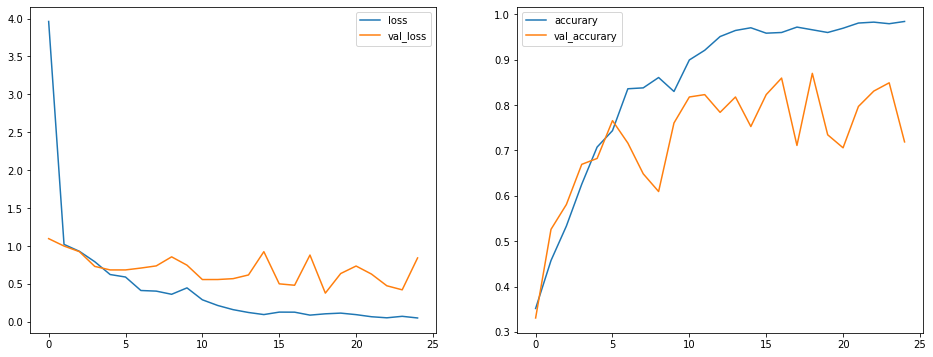

In [50]:
# Epoch 별 Loss와 Accuracy를 시각화

import matplotlib.pyplot as plt


plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()




plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],  label="accurary")
plt.plot(history.history['val_accuracy'], label="val_accurary")
plt.legend()





plt.show()

In [51]:
# 코드를 실행하세요. (label 정보)
indices = training_generator.class_indices
indices = {value : key for key, value in indices.items()}
indices

{0: 'paper', 1: 'rock', 2: 'scissors'}

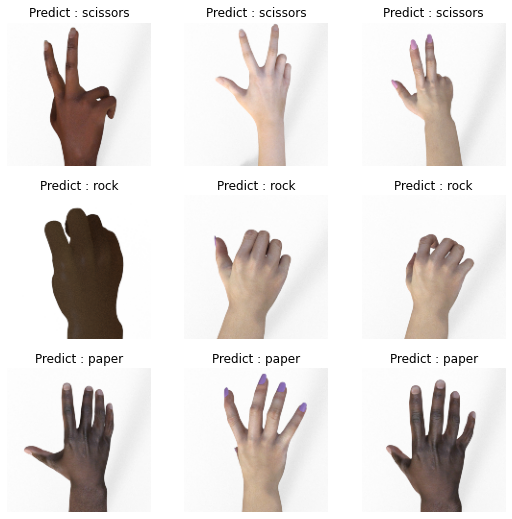

In [52]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

plt.figure(figsize = (9,9))

for i, c in enumerate(['scissors', 'rock', 'paper']) :
    files = os.listdir(f'data/rps/{c}')[:3]
    for j, file in enumerate(files) :
        plt.subplot(3,3, 3*i + j + 1)

        # 이미지 로드
        image = load_img(f'data/rps/{c}/{file}', target_size=(150, 150))
        image = img_to_array(image) / 255
        
        # plot
        plt.imshow(image)
        plt.axis(False)
        plt.title(f'Predict : {indices[model.predict(image.reshape(-1,150,150,3)).argmax()]}')
plt.show()